# DAS Data Compression using Autoencoder

This notebook shows how to do lossy DAS data compression using neural networks (Autoencoder). The original code is from [TensorFlow Compression](https://github.com/tensorflow/compression).

## Paper and posts for understanding related theories

1. [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)
2. [Image Compression Using Autoencoders in Keras](https://blog.paperspace.com/autoencoder-image-compression-keras/)
3. [AI-Based Image Compression: The State of the Art](https://towardsdatascience.com/ai-based-image-compression-the-state-of-the-art-fb5aa6042bfa)

## Setup

Install Tensorflow Compression via `pip`.

In [3]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 12.9 MB/s eta 0:00:00


Import library dependencies.

In [4]:
import glob
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from model import train_das_model, make_das_codec
from utils import extract_image_patches, prepare_das_dataset, reconstruct_image_from_patches, load_patch_from_file

plt.rcParams.update({'font.size': 14})

## Load the preprocessed DAS data from the Google Storate

In [5]:
# Mount my google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the data for trainning
file_train = sorted(glob.glob('./drive/MyDrive/DeepLearning/train/*.npz'))
file_test = sorted(glob.glob('./drive/MyDrive/DeepLearning/test/*.npz'))

print("\n--------------Trainning Dataset--------------\n")
print(file_train)

print("\n--------------Test Dataset--------------\n")
print(file_test)

Mounted at /content/drive

--------------Trainning Dataset--------------

['./drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T10-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T14-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T19-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-03_T00-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T10-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T14-00-55_p10min.npz', './drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T19-00-55_p10min.npz', './drive

In [6]:
# Plot all trainning DAS data
plt.figure(figsize=(20, 20))
for i, file in enumerate(file_train):
  # Load the data and print basic retrieved parameters
  pdata = np.load(file)['pdata']
  print(file, '    Data shape: ', pdata.shape)

  # Plot 
  plt.subplot(6, 4, i+1)
  pclip = np.percentile(pdata, 97.)
  plt.imshow(pdata, cmap='gray', aspect='auto', vmin=-pclip, vmax=pclip)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# Setup parameters for generating patches
patch_size = 32         # size of each patch
train_ratio = 0.8        # ratio between training and dev 
shuffle = True           # shuffle all patches or not
overlap = True           # overlap or not when retriving patches, i.e., tile for half patch_size
add_noise = False        # add random noise to each patch or not
snr = 10                 # value for signal-to-noise ratio

# Setup parameters for training model
lmbda = 2000         # weight for rate–distortion Lagrangian
latent_dims = 100    # layers in latent space
epochs = 20          # epoch
batch_size = 128     # batch size
learning_rate = 1e-3 # learning rate
validation_freq = 1  # validation frequency

In [39]:
# Retrive patches from save files
input_patches, ouput_patches, factors = load_patch_from_file(file_train[0:1], patch_size, overlap = overlap, add_noise = add_noise, snr = snr)

# Prepare the training and dev dataset into tensorflow
train_dataset, dev_dataset = prepare_das_dataset(input_patches, ouput_patches, train_ratio = train_ratio, shuffle = shuffle)

Loading: ./drive/MyDrive/DeepLearning/train/train_smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T10-00-55_p10min.npz
Number of patches in total:  55614


Number of train data:  44491
Number of valid data:  11123
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>


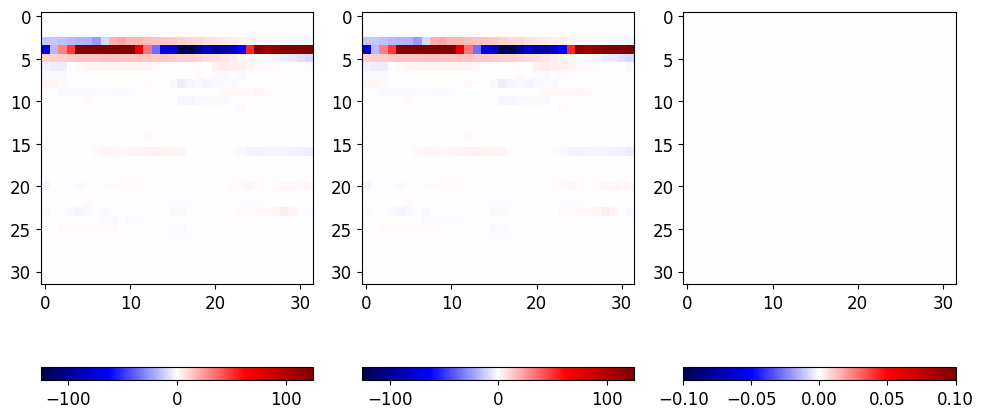

In [40]:
# check the input
idx = 20

plt.figure(figsize=(10, 5))
for i,data in enumerate([input_patches[idx], 
                         ouput_patches[idx], 
                         input_patches[idx] - ouput_patches[idx]]):
  
  pclip = np.percentile(data, 99.)
  plt.subplot(1,3,i+1)
  plt.imshow(data, cmap='seismic', vmin=-pclip, vmax=pclip)
  plt.colorbar(orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
  
plt.tight_layout()

## Train the model

In [41]:
trainer, history = train_das_model(
                    train_dataset,                         # training dataset
                    dev_dataset,                           # dev dataset
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = True)                 # launch the trainer
                    

Epoch 1/20
348/348 [==============================] - ETA: 0s - loss: 275.3247 - distortion_loss: 0.0460 - rate_loss: 183.3741 - distortion_pass_through_loss: 0.0460 - rate_pass_through_loss: 183.3485

348/348 [==============================] - 8s 13ms/step - loss: 275.3247 - distortion_loss: 0.0460 - rate_loss: 183.3741 - distortion_pass_through_loss: 0.0460 - rate_pass_through_loss: 183.3485 - val_loss: 248.3909 - val_distortion_loss: 0.0460 - val_rate_loss: 156.3486 - val_distortion_pass_through_loss: 0.0460 - val_rate_pass_through_loss: 156.3486
Epoch 2/20
348/348 [==============================] - 5s 16ms/step - loss: 233.8699 - distortion_loss: 0.0459 - rate_loss: 141.9819 - distortion_pass_through_loss: 0.0459 - rate_pass_through_loss: 141.9601 - val_loss: 206.4237 - val_distortion_loss: 0.0460 - val_rate_loss: 114.3917 - val_distortion_pass_through_loss: 0.0460 - val_rate_pass_through_loss: 114.3917
Epoch 3/20
348/348 [==============================] - 4s 11ms/step - loss: 199.5136 - distortion_loss: 0.0459 - rate_loss: 107.6270 - distortion_pass_through_loss: 0.0459 - rate_pass_through_loss: 107.6099 - val_loss: 171.2518 - val_distortion_loss: 0.0460 - val_rate_loss: 79.2186

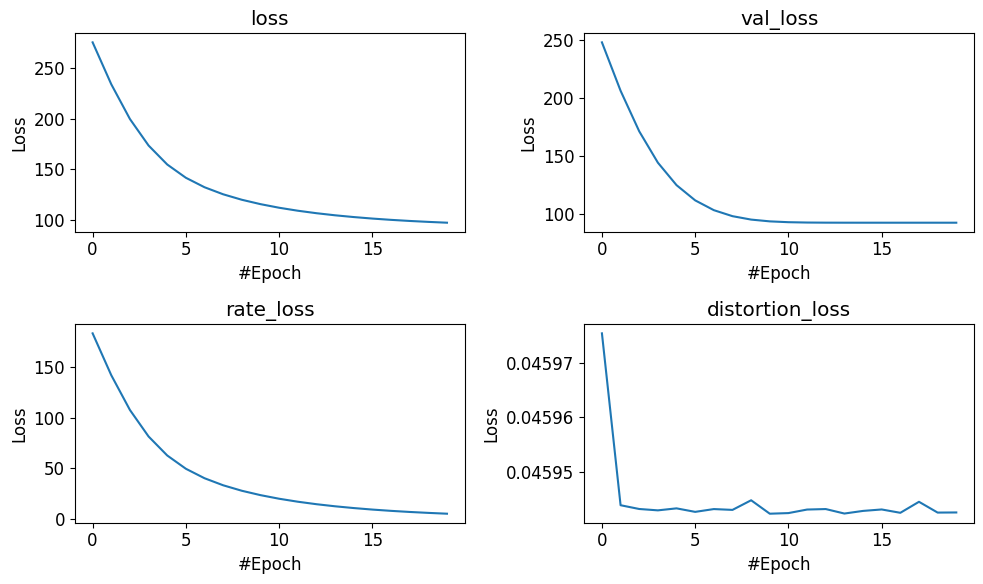

In [42]:
#history.history.keys()
loss_list = ['loss', 'val_loss', 'rate_loss', 'distortion_loss']

# Plot the rate_loss curve.
plt.figure(figsize=(10,6))
for i, l in enumerate(loss_list):
  plt.subplot(2, 2, i + 1)
  plt.plot(history.history[l])
  plt.xlabel('#Epoch')
  plt.ylabel('Loss')
  plt.title(l)

plt.tight_layout()
plt.savefig('Loss.png', dpi=300, pad_inches=0.1)
plt.show()

In [43]:
# Save the model for testing
path = "./drive/MyDrive/DeepLearning/results/"
name = f"model_patch{patch_size}_lmbda{lmbda}_latent{latent_dims}_learning_rate{learning_rate}"

trainer.save_weights(os.path.join(path, name))

In [44]:
# set the model without training
trainer_for_test, _ = train_das_model(
                    train_dataset,                         # training dataset
                    dev_dataset,                           # dev dataset
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = False)                # launch the trainer


# load the pretrained model
trainer_for_test.load_weights(os.path.join(path, name))

# Setup the trained model 
compressor, decompressor = make_das_codec(trainer_for_test)


## Test the reconstruction for whole DAS section

In [45]:
# Load the one of the test data
test_idx = 3
pdata = np.load(file_test[test_idx])['pdata']
patches_original, _, factors = extract_image_patches(pdata, patch_size, add_noise=False)
patches_original = tf.convert_to_tensor(patches_original, dtype=tf.float32)

In [48]:
# Compress them to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patches_original)

# Decompress the images back from the strings.
patches_decompre = decompressor(strings)

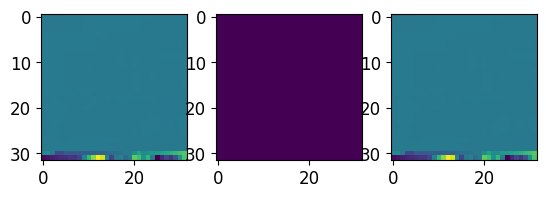

In [49]:
idx = 20
plt.subplot(1,3,1)
plt.imshow(patches_original[idx])
plt.subplot(1,3,2)
plt.imshow(patches_decompre[idx])
plt.subplot(1,3,3)
plt.imshow(patches_original[idx] - patches_decompre[idx])


In [50]:
# Load the original data just from one file
original_shape = pdata.shape
print('shape of original data: ', original_shape)

original_das = reconstruct_image_from_patches(patches_original, factors, original_shape, patch_size)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size)

shape of original data:  (4800, 900)


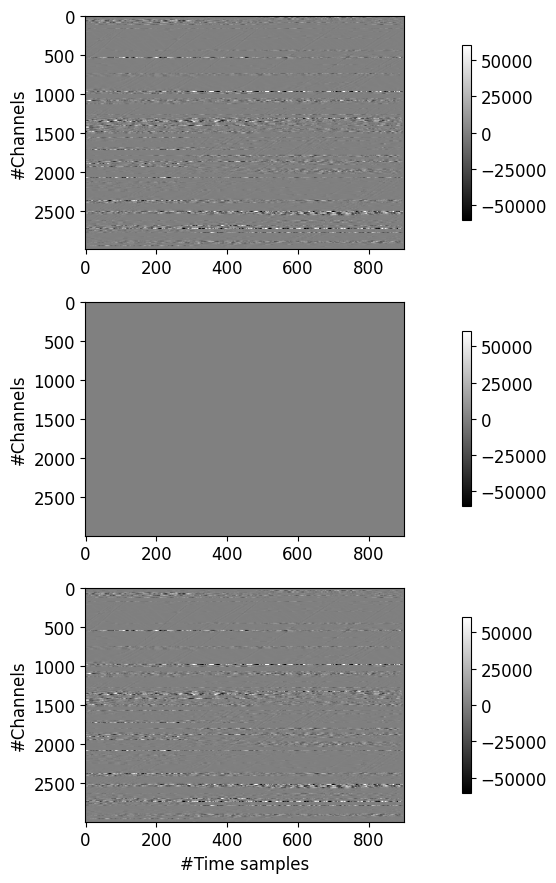

In [51]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.axes_grid1 import make_axes_locatable

nt = 2500
nc = 3000
aspect = 0.22

relloss = np.sum(np.abs(original_das - decompre_das))/np.sum(np.abs(original_das))
print
plt.subplot(311)
pclip = np.percentile(original_das, 99.)
plt.imshow(original_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(312)
plt.imshow(decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(313)
plt.imshow(original_das[:nc, :nt] - decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Difference')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.tight_layout()
plt.savefig('./drive/MyDrive/DeepLearning/Final-DAS.png', dpi=300, pad_inches=0.1)

In [ ]:
# # Save the compressed data for stand-alone test
# np.save('./drive/MyDrive/Training Dataset/original_das', original_das)
# np.save('./drive/MyDrive/Training Dataset/decompre_das', decompre_das)
# np.save('./drive/MyDrive/Training Dataset/strings.npy', strings.numpy())
# np.save('./drive/MyDrive/Training Dataset/entropies.npy', entropies.numpy())
# np.save('./drive/MyDrive/Training Dataset/patches_original.npy', patches_original.numpy())
# np.save('./drive/MyDrive/Training Dataset/factors.npy', factors)

In [ ]:
# # show the analysis_transform model
# trainer.analysis_transform.summary()

# # show the model
# trainer.synthesis_transform.summary()

# # save figures
# tf.keras.utils.plot_model(trainer.analysis_transform, to_file='model_analysis_transform.png', show_shapes=True, show_dtype=True)
# tf.keras.utils.plot_model(trainer.synthesis_transform, to_file='model_synthesis_transform.png', show_shapes=True, show_dtype=True)